# Tucker: Number of components. 
Methods used: DIFFIT, BIC, Reconstruction error, SVD

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.tenalg import multi_mode_dot
import math
from tensorly.decomposition import tucker, non_negative_tucker, non_negative_tucker_hals
from scipy.interpolate import interp1d
import tlviz
# import matlab.engine
import scipy.io
# import pyreadr
# import rpy2
from sklearn.model_selection import KFold
from scipy.linalg import svd

# Import tensors

In [3]:
tensor_70 = np.load('tensors/tensor_70.npy')
tensor_100 = np.load('tensors/tensor_100.npy')
tensor_200 = np.load('tensors/tensor_200.npy')
tensor_300 = np.load('tensors/tensor_300.npy')

tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_names = ['70', '100', '200', '300']

# DIFFIT

In [4]:
best_ranks = []
best_fits = []
valid_ranks = []
tensor = tensor_300  # change tensor
model = non_negative_tucker # change model

for i in range(1, tensor.shape[0]+1):
    for j in range(1, tensor.shape[1]+1):
        for k in range(1, tensor.shape[2]+1):
            if i <= j*k and j <= i*k and k <= i*j:
                valid_ranks.append([i, j, k])

valid_ranks = np.array(valid_ranks)

unique_s = np.unique(np.sum(valid_ranks, axis=1))

for s in unique_s:
    ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

    best_fit = 0
    best_rank = []

    for rank in ranks_s:
        core_tensor, factors = model(tensor, list(rank))

        reconstructed_tensor = tl.tucker_to_tensor((core_tensor, factors))

        fit = (np.sum(tensor**2) - np.sum((tensor - reconstructed_tensor)**2)) / np.sum(tensor**2)

        if fit > best_fit:
            best_fit = fit
            best_rank = rank

    best_ranks.append(best_rank)
    best_fits.append(best_fit)

In [5]:
#threshold
tensor = tensor_300
np.sum(tensor**2)/(tensor.shape[0]+tensor.shape[1]+tensor.shape[2]-3)

0.1358974983341603

In [6]:
df = pd.DataFrame(best_ranks, columns=['P', 'Q', 'R'])
df['Fit'] = best_fits
df.to_csv('best_ranks_and_fits.csv', index=False)

# BIC

In [7]:
def compute_BIC(tensor, core, factors, gamma):
    reconstructed_tensor = tl.tucker_to_tensor((core, factors))
    
    RSS = np.sum((tensor - reconstructed_tensor) ** 2)

    n = np.prod(tensor.shape)
    
    core_params = np.prod(core.shape)
    factor_params = sum([np.prod(f.shape) for f in factors])
    k = core_params + factor_params

    BIC = n * np.log(RSS / n) + gamma * k * np.log(n)

    return BIC

In [8]:
def bic_best_ranks(gamma_values, tensor, model,t):
    valid_ranks = []
    
    for i in range(1, tensor.shape[0] + 1):
        for j in range(1, tensor.shape[1] + 1):
            for k in range(1, tensor.shape[2] + 1):
                if i <= j * k and j <= i * k and k <= i * j and i + j + k <= t:
                    valid_ranks.append([i, j, k])

    valid_ranks = np.array(valid_ranks)
    unique_s = np.unique(np.sum(valid_ranks, axis=1))

    gamma_ranks = []
    gamma_bics = []

    for gamma in gamma_values:
        best_ranks = []
        best_bics = []
        
        for s in unique_s:
            ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

            best_bic = np.inf
            best_rank = []
        
            for rank in ranks_s:
                core_tensor, factors = model(tensor, list(rank))
                bic = compute_BIC(tensor, core_tensor, factors, gamma)

                if bic < best_bic:
                    best_bic = bic
                    best_rank = rank

            best_ranks.append(best_rank)
            best_bics.append(best_bic)

        gamma_ranks.append(best_ranks)
        gamma_bics.append(best_bics)

    return gamma_ranks, gamma_bics

In [9]:
# normal tucker
gamma_ranks_70, gamma_bics_70 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_70, tucker, 15)
gamma_ranks_100, gamma_bics_100 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_100, tucker, 15)
gamma_ranks_200, gamma_bics_200 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_200, tucker, 15)
gamma_ranks_300, gamma_bics_300 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_300, tucker, 15)

In [10]:
def visualize_gamma_lists(gamma_lists, x_values):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, gamma_bics in enumerate(gamma_lists):
        ax = axes[idx] 

        for i, y_values in enumerate(gamma_bics):
            ax.plot(x_values, y_values, marker='o', label=f'gamma {i+1}')
        if idx == 0:
            idx = 0.7
        ax.set_xlabel('Number of components')
        ax.set_ylabel('BIC Value')
        ax.set_title(f'BIC Values for Tensor {int(idx*100)}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

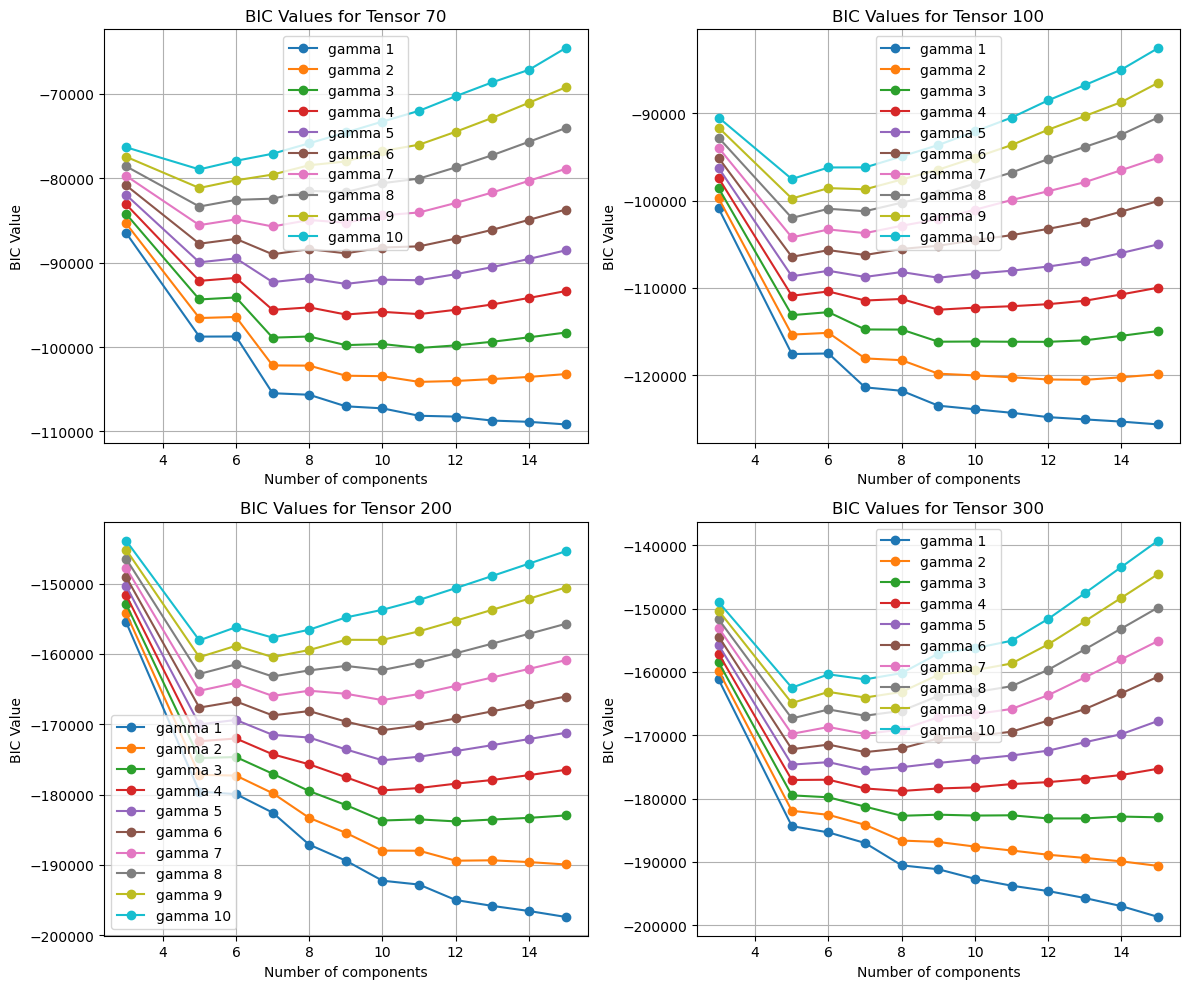

In [11]:
gamma_lists = [gamma_bics_70, gamma_bics_100, gamma_bics_200, gamma_bics_300]
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visualize_gamma_lists(gamma_lists, x_values)

In [12]:
for i in range(len(gamma_ranks_70)):
    print("For gamma {}, the best rank is {} for tensor_70, {} for tensor_100, {} for tensor_200 and {} for tensor_300.".format(i+1, gamma_ranks_70[i][gamma_bics_70[i].index(min(gamma_bics_70[i]))],gamma_ranks_100[i][gamma_bics_100[i].index(min(gamma_bics_100[i]))],gamma_ranks_200[i][gamma_bics_200[i].index(min(gamma_bics_200[i]))],gamma_ranks_300[i][gamma_bics_300[i].index(min(gamma_bics_300[i]))]))

For gamma 1, the best rank is [5 3 7] for tensor_70, [5 4 6] for tensor_100, [5 4 6] for tensor_200 and [6 3 6] for tensor_300.
For gamma 2, the best rank is [3 3 5] for tensor_70, [3 4 6] for tensor_100, [5 4 6] for tensor_200 and [5 4 6] for tensor_300.
For gamma 3, the best rank is [3 3 5] for tensor_70, [3 4 5] for tensor_100, [4 3 5] for tensor_200 and [4 3 5] for tensor_300.
For gamma 4, the best rank is [3 2 4] for tensor_70, [3 2 4] for tensor_100, [3 3 4] for tensor_200 and [3 2 3] for tensor_300.
For gamma 5, the best rank is [3 2 4] for tensor_70, [3 2 4] for tensor_100, [3 3 4] for tensor_200 and [2 2 3] for tensor_300.
For gamma 6, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 3 4] for tensor_200 and [2 2 3] for tensor_300.
For gamma 7, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 3 4] for tensor_200 and [2 2 3] for tensor_300.
For gamma 8, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 2 3] for tensor_200 and 

In [13]:
# non-negative tucker
gamma_ranks_70_nn, gamma_bics_70_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_70, non_negative_tucker, 15)
gamma_ranks_100_nn, gamma_bics_100_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_100, non_negative_tucker, 15)
gamma_ranks_200_nn, gamma_bics_200_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_200, non_negative_tucker, 15)
gamma_ranks_300_nn, gamma_bics_300_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_300, non_negative_tucker, 15)

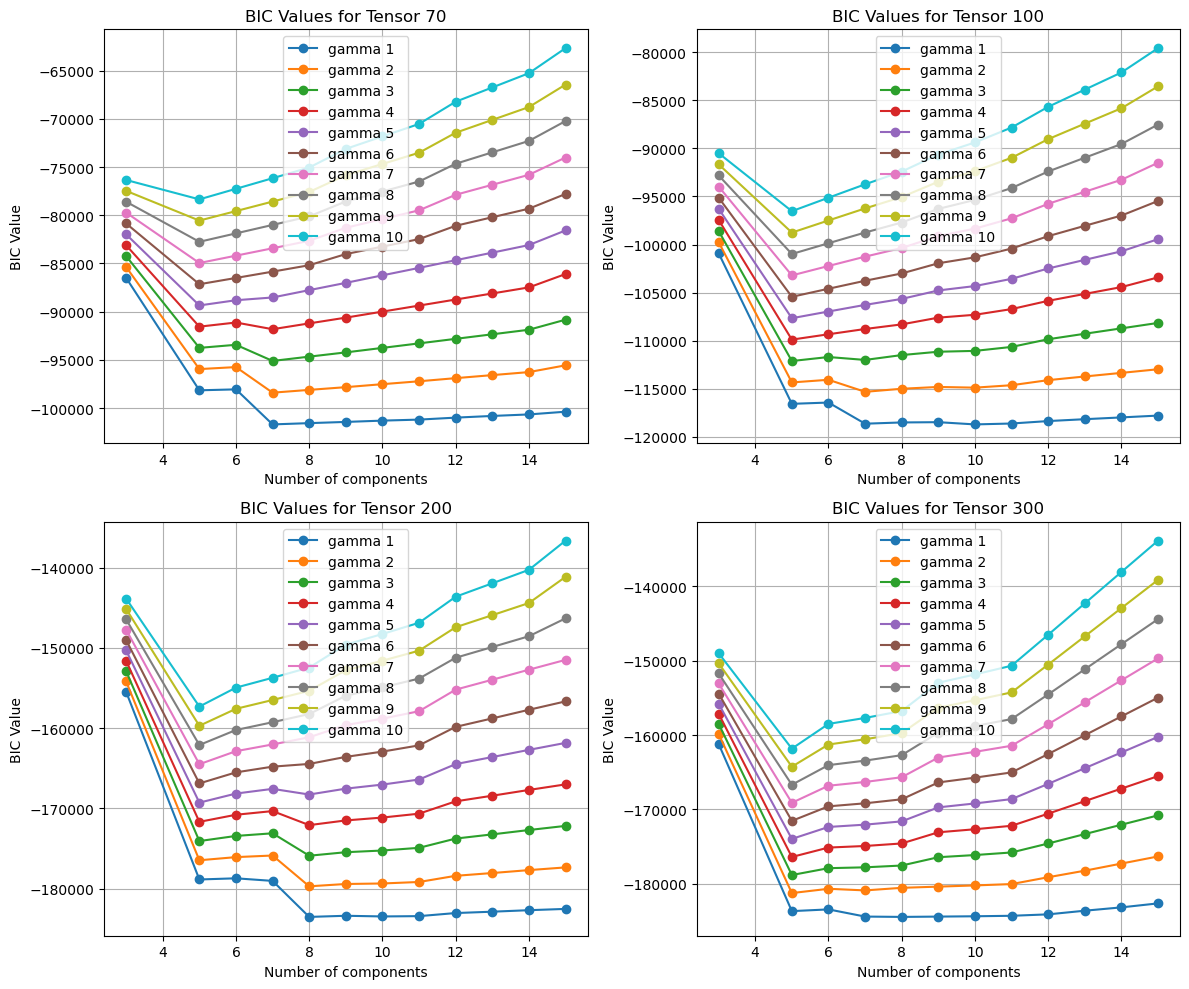

In [14]:
gamma_lists = [gamma_bics_70_nn, gamma_bics_100_nn, gamma_bics_200_nn, gamma_bics_300_nn]
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visualize_gamma_lists(gamma_lists, x_values)

In [15]:
for i in range(len(gamma_ranks_70_nn)):
    print("For gamma {}, the best rank is {} for tensor_70, {} for tensor_100, {} for tensor_200 and {} for tensor_300.".format(i+1, gamma_ranks_70_nn[i][gamma_bics_70_nn[i].index(min(gamma_bics_70_nn[i]))],gamma_ranks_100_nn[i][gamma_bics_100_nn[i].index(min(gamma_bics_100_nn[i]))],gamma_ranks_200_nn[i][gamma_bics_200_nn[i].index(min(gamma_bics_200_nn[i]))],gamma_ranks_300_nn[i][gamma_bics_300_nn[i].index(min(gamma_bics_300_nn[i]))]))

For gamma 1, the best rank is [3 1 3] for tensor_70, [3 2 5] for tensor_100, [3 2 3] for tensor_200 and [3 2 3] for tensor_300.
For gamma 2, the best rank is [3 1 3] for tensor_70, [3 1 3] for tensor_100, [3 2 3] for tensor_200 and [2 1 2] for tensor_300.
For gamma 3, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 2 3] for tensor_200 and [2 1 2] for tensor_300.
For gamma 4, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 2 3] for tensor_200 and [2 1 2] for tensor_300.
For gamma 5, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and [2 1 2] for tensor_300.
For gamma 6, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and [2 1 2] for tensor_300.
For gamma 7, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and [2 1 2] for tensor_300.
For gamma 8, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and 

# (Igual quitar) Reconstruction error 

In [16]:
# we create a list with the tensors for more efficient coding
tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_names = ['70', '100', '200', '300']

In [17]:
def error(original, res):
    # res is in CP
    if isinstance(res, CPTensor):
        res = res.to_tensor()
    
    # deal with cases when res is Tucker
    if isinstance(res, TuckerTensor):
        res = tucker_to_tensor(res)
        
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

In [18]:
def best_errors(tensor, model):
    valid_ranks = []
    
    for i in range(1, tensor.shape[0] + 1):
        for j in range(1, tensor.shape[1] + 1):
            for k in range(1, tensor.shape[2] + 1):
                if i <= j * k and j <= i * k and k <= i * j and i + j + k <= 15:
                    valid_ranks.append([i, j, k])

    valid_ranks = np.array(valid_ranks)
    unique_s = np.unique(np.sum(valid_ranks, axis=1))

    best_ranks = []
    best_errors = []
    
    for s in unique_s:
        ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

        best_err = np.inf
        best_rank = []
    
        for rank in ranks_s:
            model_ = model(tensor, list(rank))
            err = error(tensor, model_)

            if err < best_err:
                best_err = err
                best_rank = rank

        best_ranks.append(best_rank)
        best_errors.append(best_err)

    return best_ranks, best_errors

In [19]:
#normal tucker
best_ranks_70, best_errors_70 = best_errors(tensor_70, tucker)
best_ranks_100, best_errors_100 = best_errors(tensor_100, tucker)
best_ranks_200, best_errors_200 = best_errors(tensor_200, tucker)
best_ranks_300, best_errors_300 = best_errors(tensor_300, tucker)

In [20]:
def visualize_errors(x_values, y_values):
    fig, axes = plt.subplots(2, 2, figsize=(7, 6)) 
    axes = axes.flatten() 
    
    for i, y_values in enumerate(y_values):
        ax = axes[i] 
    
        ax.plot(x_values, y_values, marker='o', linestyle='-')
        if i==0:
            i = 0.7
        ax.set_title(f'Reconstruction error for Tensor {int(i*100)}')
        #ax.grid(True)
    
    plt.tight_layout()  # Adjust layout
    plt.show()

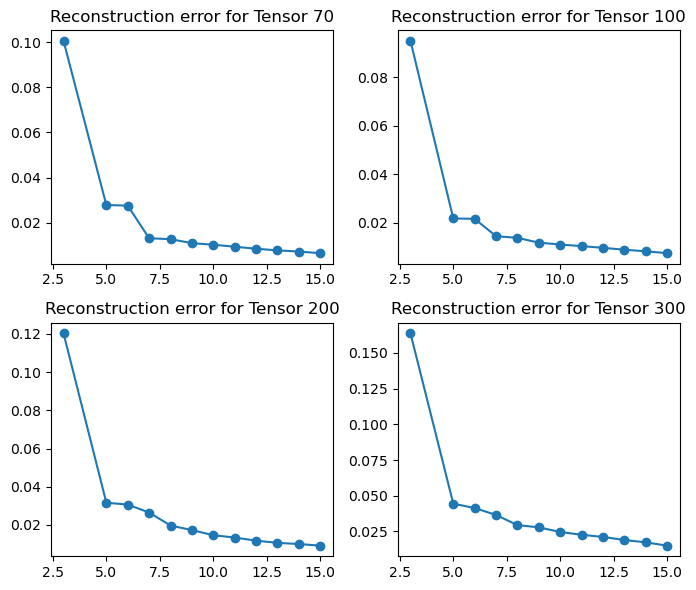

In [21]:
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_values = [best_errors_70, best_errors_100, best_errors_200, best_errors_300]
visualize_errors(x_values, y_values)

In [22]:
#non negative tucker
best_ranks_70_nn, best_errors_70_nn = best_errors(tensor_70, non_negative_tucker)
best_ranks_100_nn, best_errors_100_nn = best_errors(tensor_100, non_negative_tucker)
best_ranks_200_nn, best_errors_200_nn = best_errors(tensor_200, non_negative_tucker)
best_ranks_300_nn, best_errors_300_nn = best_errors(tensor_300, non_negative_tucker)

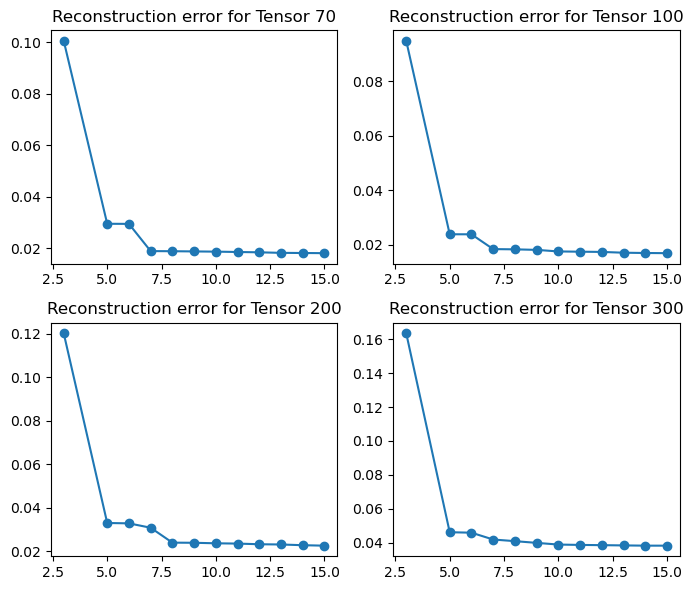

In [23]:
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_values = [best_errors_70_nn, best_errors_100_nn, best_errors_200_nn, best_errors_300_nn]
visualize_errors(x_values, y_values)

# SVD 

## Relative error

In [24]:
def estimate_tucker_ranks(tensor, threshold=0.01):
    ranks = []
    for mode in range(tensor.ndim):
        matricized = tl.unfold(tensor,mode)
        
        U, S, Vt = svd(matricized, full_matrices=False)

        error_r = 1 - np.sqrt(np.cumsum(S**2) / np.sum(S**2))
        rank = np.where(error_r < threshold)[0][0] + 1
        ranks.append(rank)
    
    return tuple(ranks)

In [25]:
estimated_ranks_70 = estimate_tucker_ranks(tensor_70)
print("Estimated Tucker Ranks for tensor_70:", estimated_ranks_70)
estimated_ranks_100 = estimate_tucker_ranks(tensor_100)
print("Estimated Tucker Ranks for tensor_100:", estimated_ranks_100)
estimated_ranks_200 = estimate_tucker_ranks(tensor_200)
print("Estimated Tucker Ranks for tensor_200:", estimated_ranks_200)
estimated_ranks_300 = estimate_tucker_ranks(tensor_300)
print("Estimated Tucker Ranks for tensor_300:", estimated_ranks_300)

Estimated Tucker Ranks for tensor_70: (3, 1, 3)
Estimated Tucker Ranks for tensor_100: (2, 1, 3)
Estimated Tucker Ranks for tensor_200: (3, 2, 3)
Estimated Tucker Ranks for tensor_300: (4, 2, 3)


## Variance vs. reconstruction error

In [26]:
from scipy.linalg import svd
from kneed import KneeLocator 

# Function to compute reconstruction error
def error(original, res):
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)


def compute_svd_ranks(tensor, tensor_name, threshold=0.75, error_threshold=0.05, method="variance", plot_s=False):
    """
    Computes the optimal rank for each mode using SVD, selecting ranks based on 
    either variance retention or reconstruction error. Plots all three modes in 
    a single figure for better visualization.

    Parameters:
    tensor (np.array): The input tensor
    tensor_name (str): The name of the tensor (for labeling plots)
    threshold (float): The percentage of variance to retain when choosing ranks (used for variance method)
    error_threshold (float): The acceptable reconstruction error threshold (used for reconstruction error method)
    method (str): Selection method - "variance" or "reconstruction_error"

    Returns:
    ranks_selected (list): Selected ranks for each mode
    """
    ranks_selected = []
    thres_rank = []

    # Create a single figure with 3 subplots (one for each mode)
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    fig.suptitle(f"{'Cumulative Variance' if method == 'variance' else 'Reconstruction Error'} for tensor_{tensor_name}", fontsize=14)

    if plot_s == True:
        # Create a single figure with 3 subplots (one for each mode)
        fig2, axes2 = plt.subplots(1, 3, figsize=(17, 5))
        fig2.suptitle("Singular values", fontsize=14)

    for mode in range(tl.ndim(tensor)):
        # Matricize tensor along the mode
        matricized = tl.unfold(tensor, mode)
        
        # print(f'Original shape: {tensor.shape}')
        # print(f'Matricized shape: {matricized.shape}')
        U, S, Vt = svd(matricized, full_matrices=False)
        # print(S)
        # print(S.shape)
        # plt.figure()
        # plt.bar(np.arange(1, len(S) + 1),S)
        # plt.xlabel('singular value position')
        # plt.ylabel('singular value')
        # plt.title(f'Mode {mode}')

        if plot_s == True:
            axes2[mode].bar(np.arange(1, len(S) + 1),S)
            axes2[mode].set_xlabel('Singular value position')
            axes2[mode].set_ylabel('Singular value')
            axes2[mode].set_title(f'Mode {mode}')

        if method == "variance":
            # Compute cumulative explained variance
            cumulative_variance = np.cumsum(S**2) / np.sum(S**2)

            # Select rank based on variance threshold
            # selected_rank = np.searchsorted(cumulative_variance, threshold) + 1
            selected_rank = np.where(cumulative_variance > threshold)[0][0] + 1
            thres_rank.append(selected_rank)

            # Elbow Method: Automatically detect the best rank
            elbow_locator = KneeLocator(np.arange(1, len(S) + 1), cumulative_variance, curve="concave", direction="increasing")
            selected_rank_elbow = elbow_locator.knee if elbow_locator.knee else selected_rank
            

            # Plot variance retention
            ax = axes[mode]
            ax.plot(np.arange(1, len(S) + 1), cumulative_variance, marker='o', linestyle='-', label='Cumulative Variance')
            if selected_rank_elbow:
                ax.axvline(x=selected_rank_elbow, color='r', linestyle='--', label='Elbow')
                ax.axvline(x=selected_rank, color='k', linestyle='--', label=f'Threshold ({threshold})')

            ax.set_ylabel("Cumulative Explained Variance")
            # print(f'Mode {mode}')
            # print(f'    Var rank: {selected_rank}, Elbow rank: {selected_rank_elbow}')

        elif method == "reconstruction_error":
            # Compute reconstruction errors
            ranks = np.arange(1, len(S) + 1)
            errors = np.zeros_like(ranks, dtype=float)

            for i, r in enumerate(ranks):
                reconstructed = (U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :])
                errors[i] = error(matricized, reconstructed)

            # Detect elbow point
            selected_rank = np.where(errors < error_threshold)[0][0] + 1
            thres_rank.append(selected_rank)
            elbow_locator = KneeLocator(ranks, errors, curve="convex", direction="decreasing")
            selected_rank_elbow = elbow_locator.knee or ranks[-1]

            # Plot
            ax = axes[mode]
            ax.plot(ranks, errors, color='g', marker='o', linestyle='-', label=f"Reconstruction Error")
            ax.axvline(selected_rank_elbow, color='r', linestyle='--', label="Elbow")
            ax.axvline(x=selected_rank, color='k', linestyle='--', label=f'Threshold ({error_threshold})')

            ax.set_ylabel("Reconstruction Error")
            # ax.set_yscale("log")  # Log scale for better visualization

        else:
            raise ValueError("Invalid method. Choose 'variance' or 'reconstruction_error'.")

        # Append the selected rank for this mode
        ranks_selected.append(selected_rank_elbow)
    

        # Labels & Titles
        ax.set_xlabel("Number of Ranks")
        ax.set_title(f"Mode {mode}")
        ax.grid()

    # Show a shared legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.show()
    
    if method == 'reconstruction_error':
        return ranks_selected, thres_rank
    elif method == 'variance':
        return ranks_selected, thres_rank

Rank selection for tensor_70


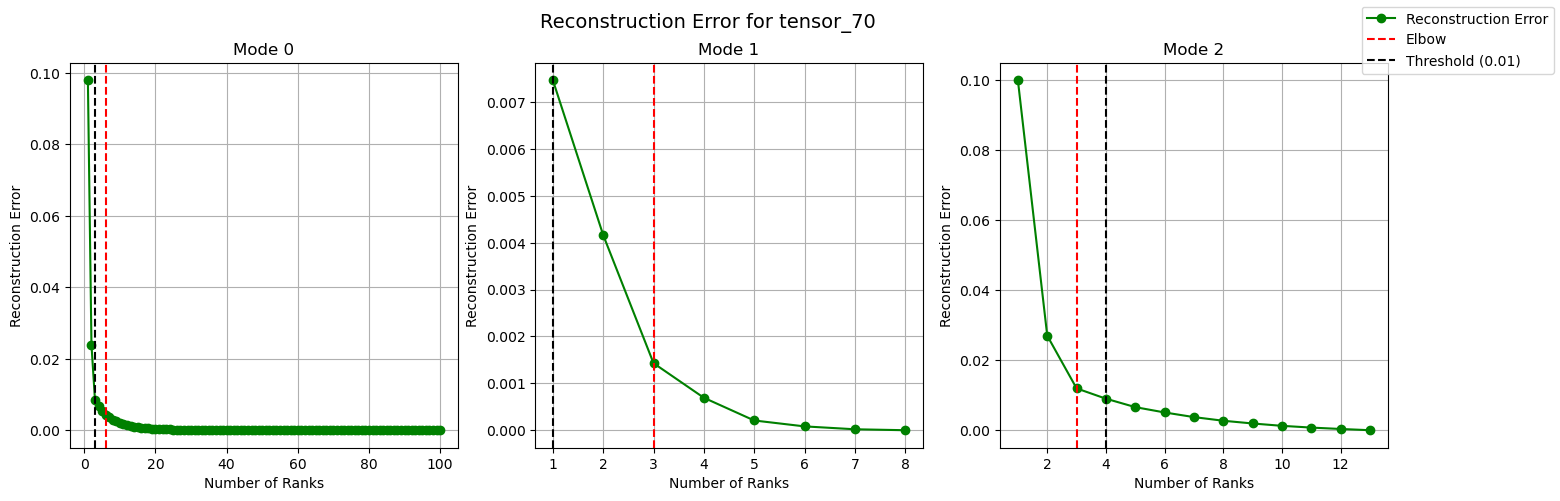

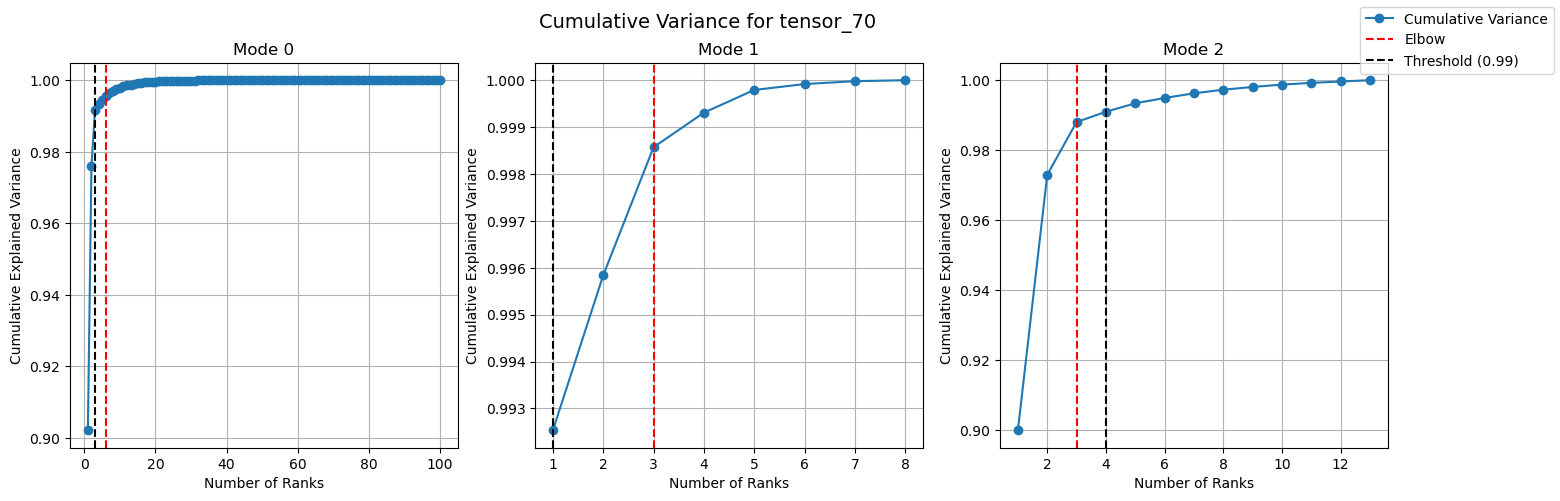

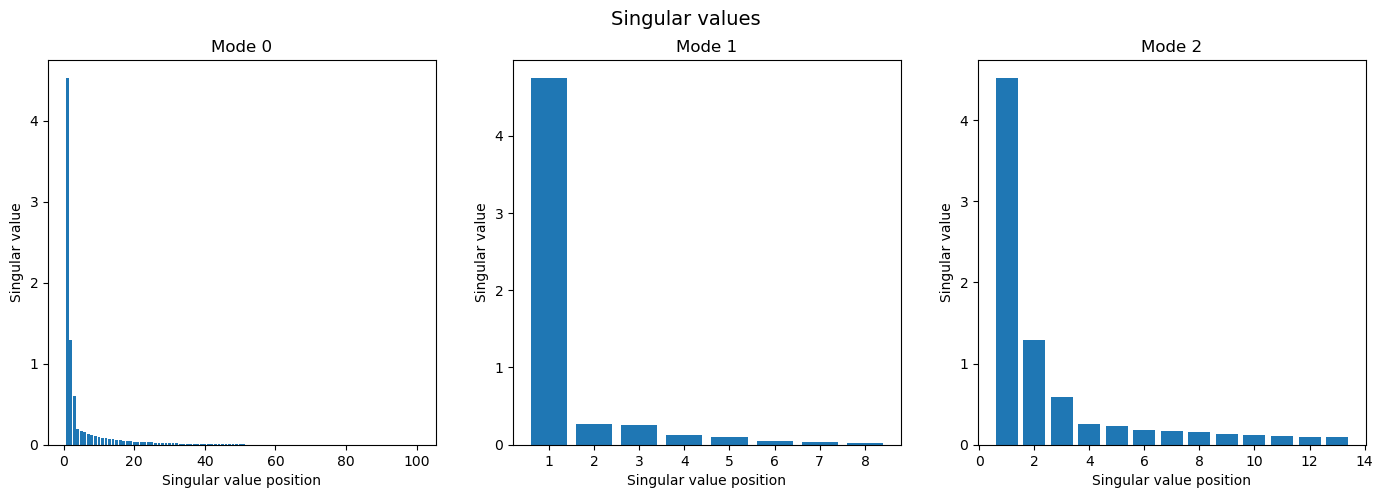

Rank selection for tensor_100


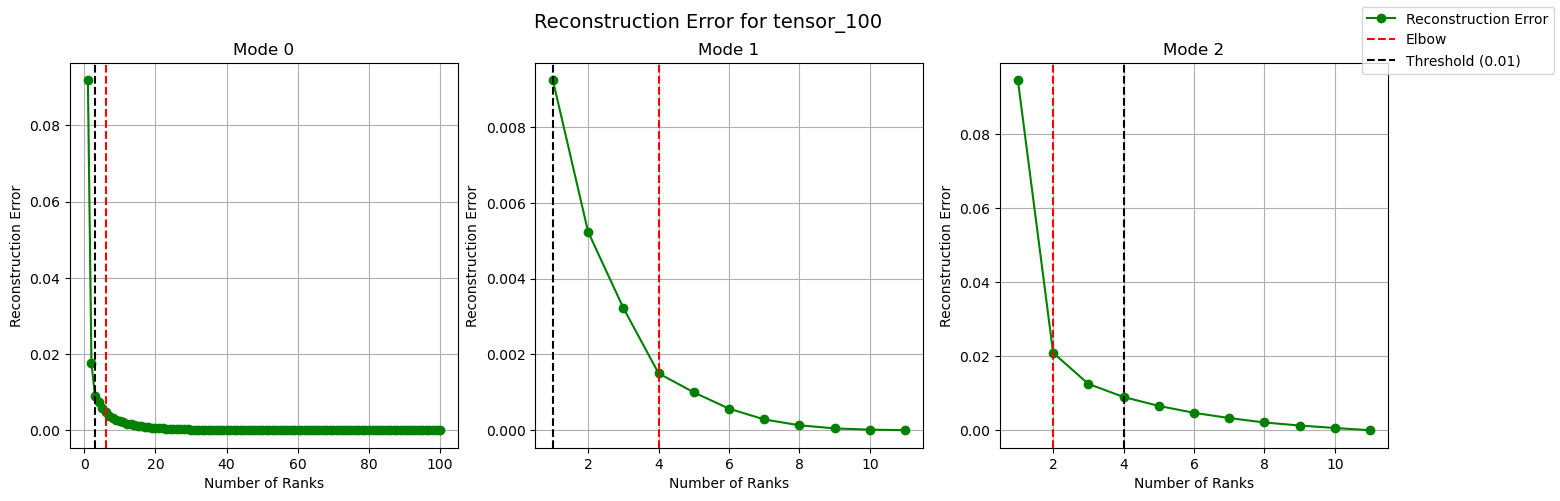

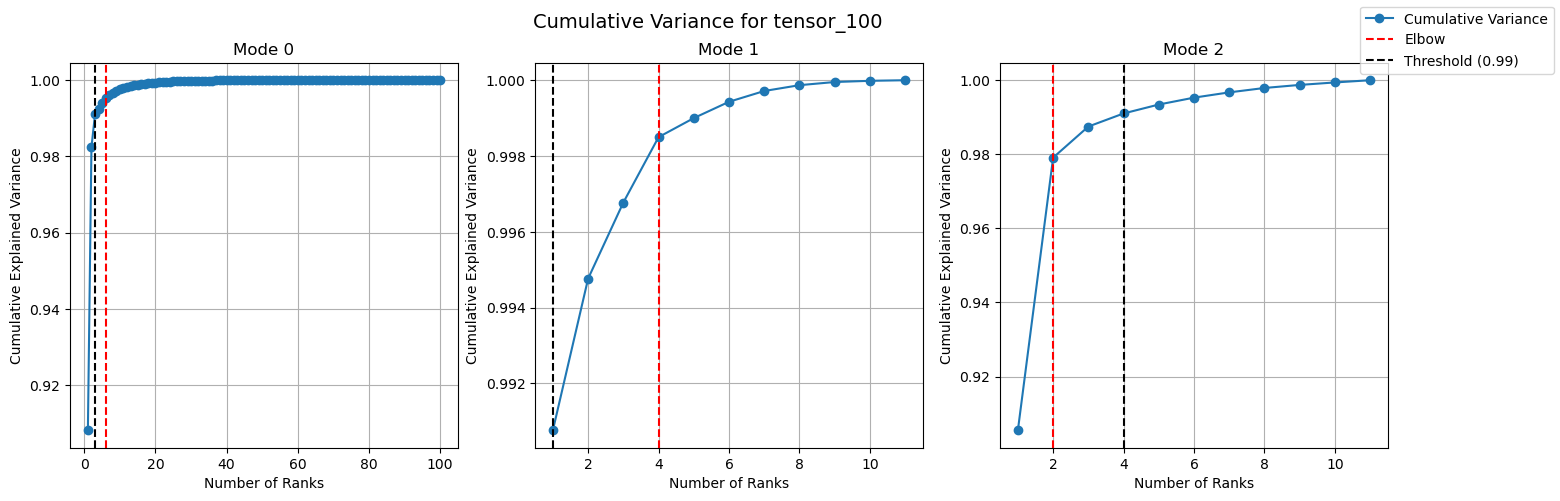

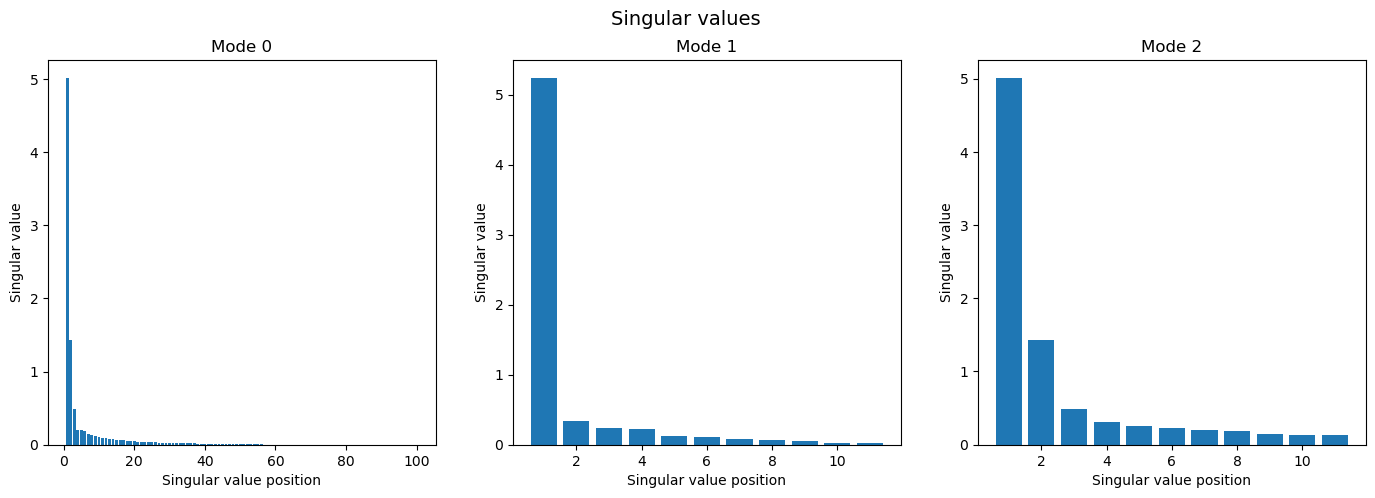

Rank selection for tensor_200


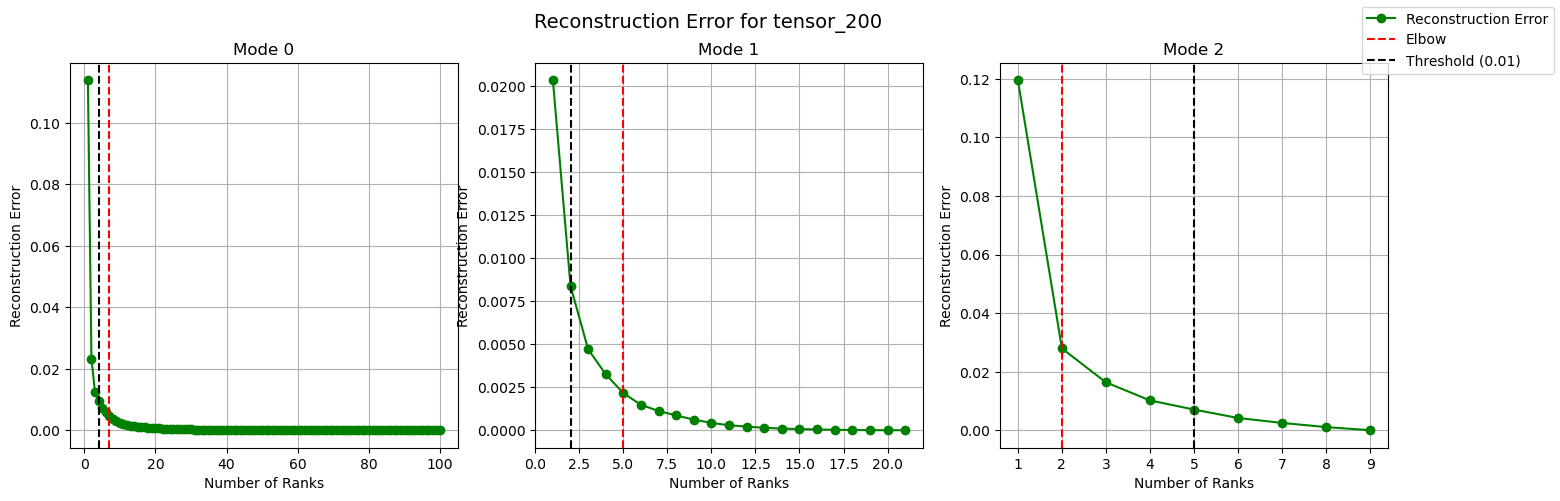

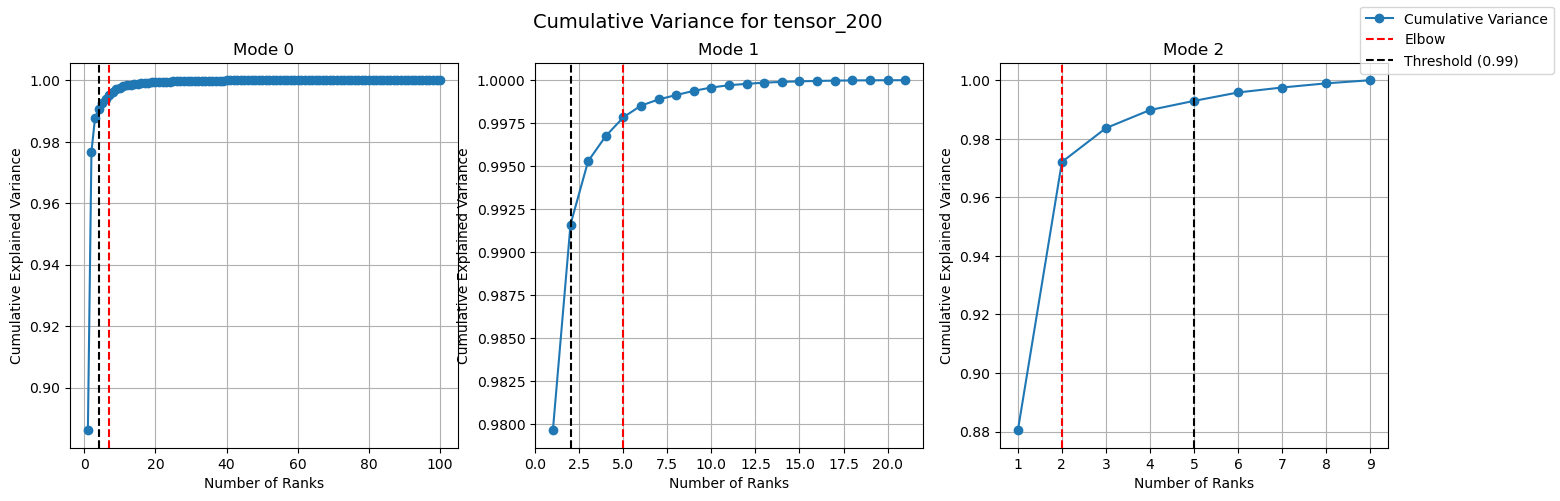

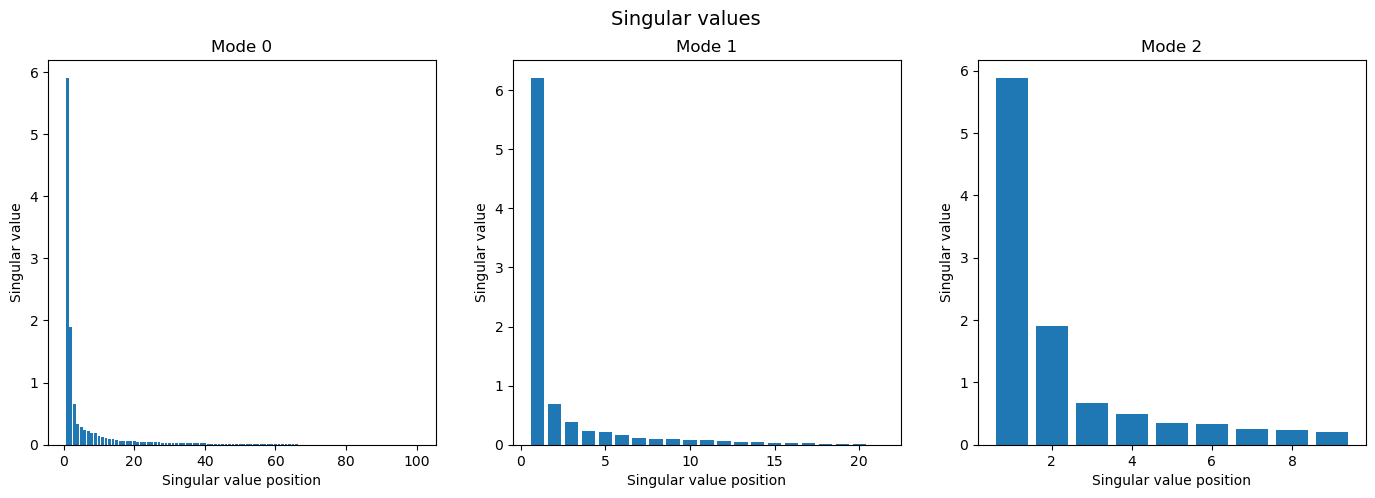

Rank selection for tensor_300


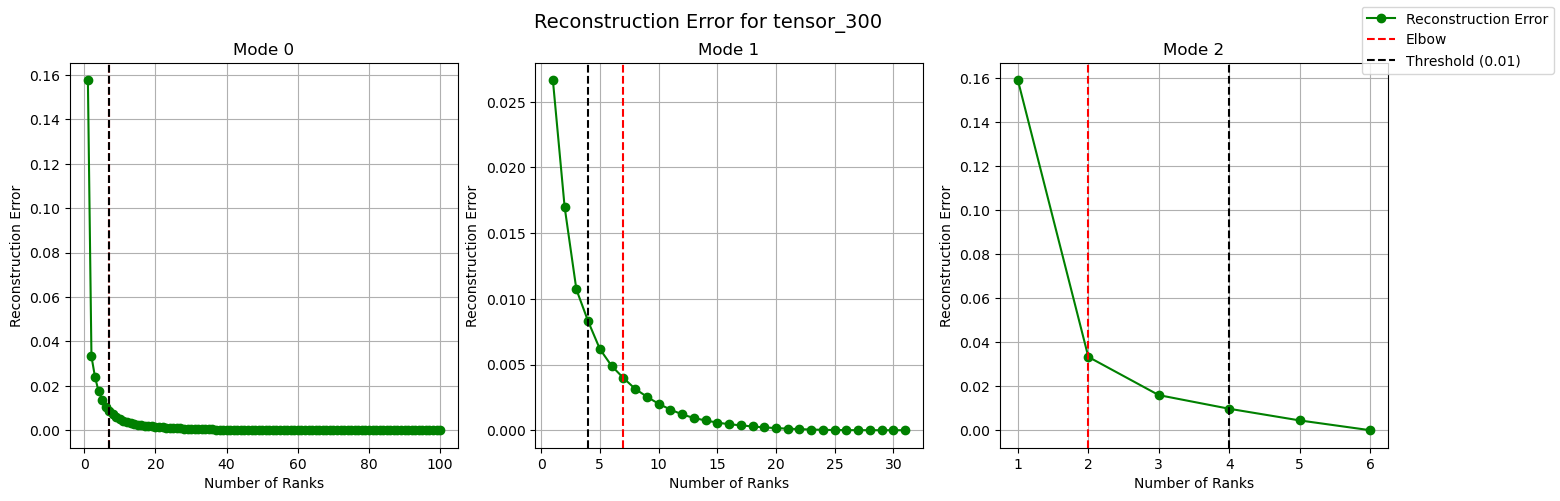

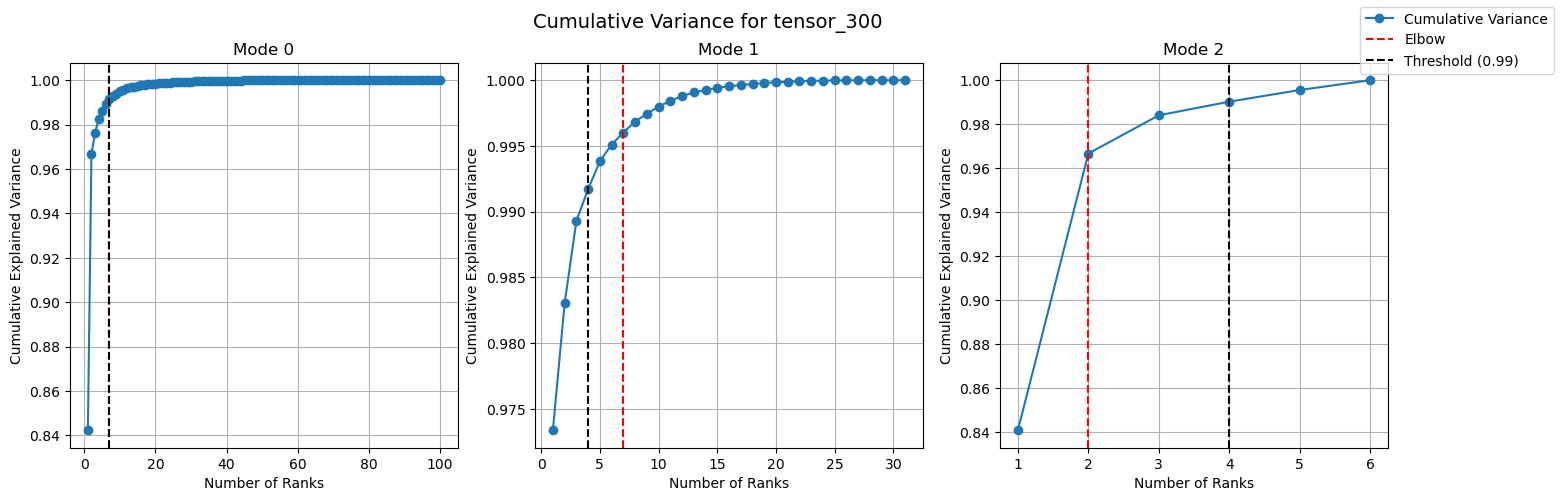

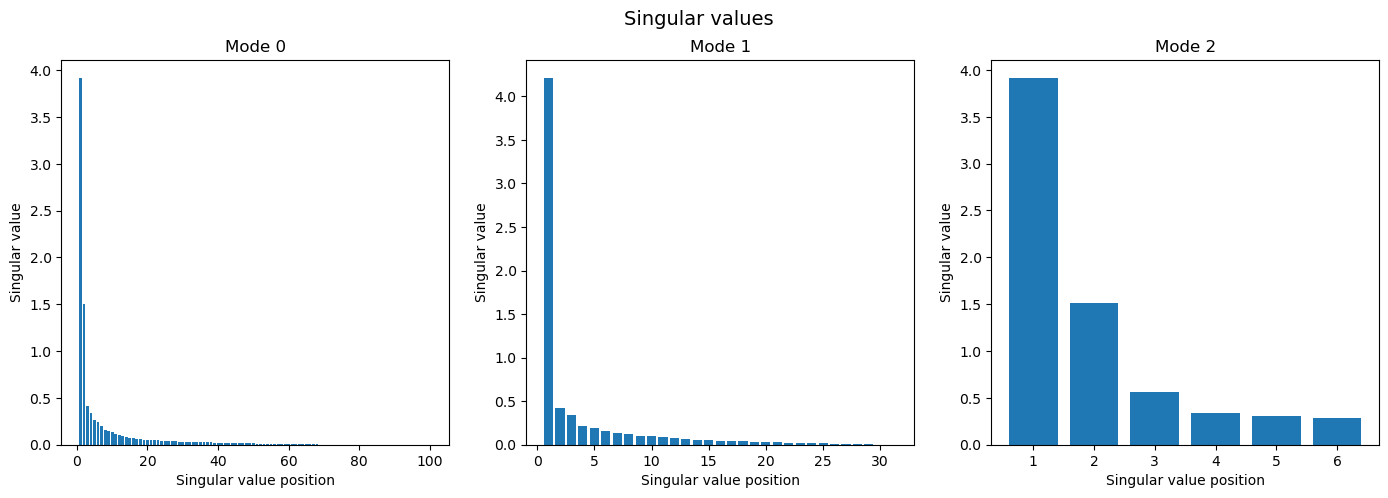


FINAL RANKS (Explained Variance - threshold=0.99):
    Final Ranks for tensor_70: elbow --> [6, 3, 3], threshold --> [3, 1, 4]
    Final Ranks for tensor_100: elbow --> [6, 4, 2], threshold --> [3, 1, 4]
    Final Ranks for tensor_200: elbow --> [7, 5, 2], threshold --> [4, 2, 5]
    Final Ranks for tensor_300: elbow --> [7, 7, 2], threshold --> [7, 4, 4]

FINAL RANKS (Reconstruction Error - threshold=0.01):
    Final Ranks for tensor_70: elbow --> [6, 3, 3], threshold --> [3, 1, 4]
    Final Ranks for tensor_100: elbow --> [6, 4, 2], threshold --> [3, 1, 4]
    Final Ranks for tensor_200: elbow --> [7, 5, 2], threshold --> [4, 2, 5]
    Final Ranks for tensor_300: elbow --> [7, 7, 2], threshold --> [7, 4, 4]


In [27]:
# Run for all our tensors using Variance Method
final_ranks_variance = []  
final_ranks_thresh = []
final_ranks_reconstruction = []  
final_ranks_reconstruction_thresh = []  

threshold = 0.99  # Variance retention threshold
error_threshold = 0.01  # Acceptable reconstruction error threshold

for i, tensor in enumerate(tensors):
    tensor_name = tensor_names[i]  # To label the tensor (e.g., time 70, 100, 200, 300)
    print(f'Rank selection for tensor_{tensor_name}')

    # Compute ranks using Reconstruction Error-based selection
    selected_ranks_reconstruction, error_thres_ranks = compute_svd_ranks(tensor, tensor_name, threshold=threshold, error_threshold=error_threshold, method="reconstruction_error")
    final_ranks_reconstruction.append(selected_ranks_reconstruction)
    final_ranks_reconstruction_thresh.append(error_thres_ranks)

    # Compute ranks using Variance-based selection
    selected_ranks_variance, thres_ranks = compute_svd_ranks(tensor, tensor_name, threshold=threshold, error_threshold=error_threshold, method="variance", plot_s=True)
    final_ranks_variance.append(selected_ranks_variance)
    final_ranks_thresh.append(thres_ranks)

    

# Print final ranks for Variance method
print(f'\nFINAL RANKS (Explained Variance - threshold={threshold}):')
for i, tensor in enumerate(tensors):
    print(f"    Final Ranks for tensor_{tensor_names[i]}: elbow --> {final_ranks_variance[i]}, threshold --> {final_ranks_thresh[i]}")

# Print final ranks for Reconstruction Error method
print(f'\nFINAL RANKS (Reconstruction Error - threshold={error_threshold}):')
for i, tensor in enumerate(tensors):
    print(f"    Final Ranks for tensor_{tensor_names[i]}: elbow --> {final_ranks_reconstruction[i]}, threshold --> {final_ranks_reconstruction_thresh[i]}")


# Components comparison
We want to compare the above methods globally:

1. Factor Matrices → How similar are the components across all methods?
2. Core Tensors → Do the decompositions represent the same latent structure?
3. Reconstruction Errors → Which method best reconstructs the data?

In [38]:
# For DIFIT - from csv files, best to use
ranks_DIFIT = {
    "tensor_70": [3,1,3],
    "tensor_100": [2,1,1],
    "tensor_200": [3,2,3], # or 2,1,2
    "tensor_300": [2,1,2]
}
print('\n DIFIT ranks')
print(ranks_DIFIT)

# For BIC:
# i=1 gamma=1 has best BIC
ranks_BIC = {
    "tensor_70": list(gamma_ranks_70_nn[i][gamma_bics_70_nn[i].index(min(gamma_bics_70_nn[i]))]),
    "tensor_100": list(gamma_ranks_100_nn[i][gamma_bics_100_nn[i].index(min(gamma_bics_100_nn[i]))]),
    "tensor_200": list(gamma_ranks_200_nn[i][gamma_bics_200_nn[i].index(min(gamma_bics_200_nn[i]))]),
    "tensor_300": list(gamma_ranks_300_nn[i][gamma_bics_300_nn[i].index(min(gamma_bics_300_nn[i]))])
}
print('\nBIC ranks (for gamma=1)')
print(ranks_BIC)



# For SVD:

# For relative error:
# La vd no se como coger los rangos, de momento se queda vacio
ranks_rec_error = {
    "tensor_70": estimated_ranks_70,
    "tensor_100": estimated_ranks_100,
    "tensor_200": estimated_ranks_200,
    "tensor_300": estimated_ranks_300,
}
print('\nSVD Relative error')
print(ranks_rec_error)

# For variance (relative error + 1)
ranks_SVD_var_elbow = {
    "tensor_70": final_ranks_variance[0],
    "tensor_100": final_ranks_variance[1],
    "tensor_200": final_ranks_variance[2],
    "tensor_300": final_ranks_variance[3],
}
print('\nSVD variance ranks (elbow)')
print(ranks_SVD_var_elbow)

ranks_SVD_var_thresh = {
    "tensor_70": final_ranks_thresh[0],
    "tensor_100": final_ranks_thresh[1],
    "tensor_200": final_ranks_thresh[2],
    "tensor_300": final_ranks_thresh[3],
}
print('\nSVD variance ranks (threshold)')
print(ranks_SVD_var_thresh)

ranks_SVD_recon_error_elbow = {
    "tensor_70": final_ranks_reconstruction[0],
    "tensor_100": final_ranks_reconstruction[1],
    "tensor_200": final_ranks_reconstruction[2],
    "tensor_300": final_ranks_reconstruction[3],
}
print('\nSVD reconstruction error ranks (elbow)')
print(ranks_SVD_recon_error_elbow)

ranks_SVD_recon_error_thresh = {
    "tensor_70": final_ranks_reconstruction_thresh[0],
    "tensor_100": final_ranks_reconstruction_thresh[1],
    "tensor_200": final_ranks_reconstruction_thresh[2],
    "tensor_300": final_ranks_reconstruction_thresh[3],
}
print('\nSVD reconstruction error ranks (threshold)')
print(ranks_SVD_recon_error_thresh)

rank_dictionaries = {
    "DIFIT": ranks_DIFIT,
    "BIC": ranks_BIC,
    "SVD Relative Error": ranks_rec_error,
    "SVD Variance (Elbow)": ranks_SVD_var_elbow,
    "SVD Variance (Threshold)": ranks_SVD_var_thresh,
    "SVD Reconstruction Error (Elbow)": ranks_SVD_recon_error_elbow,
    "SVD Reconstruction Error (Threshold)": ranks_SVD_recon_error_thresh
}




 DIFIT ranks
{'tensor_70': [3, 1, 3], 'tensor_100': [2, 1, 1], 'tensor_200': [3, 2, 3], 'tensor_300': [2, 1, 2]}

BIC ranks (for gamma=1)
{'tensor_70': [3, 1, 3], 'tensor_100': [2, 1, 2], 'tensor_200': [3, 2, 3], 'tensor_300': [2, 1, 2]}

SVD Relative error
{'tensor_70': (3, 1, 3), 'tensor_100': (2, 1, 3), 'tensor_200': (3, 2, 3), 'tensor_300': (4, 2, 3)}

SVD variance ranks (elbow)
{'tensor_70': [6, 3, 3], 'tensor_100': [6, 4, 2], 'tensor_200': [7, 5, 2], 'tensor_300': [7, 7, 2]}

SVD variance ranks (threshold)
{'tensor_70': [3, 1, 4], 'tensor_100': [3, 1, 4], 'tensor_200': [4, 2, 5], 'tensor_300': [7, 4, 4]}

SVD reconstruction error ranks (elbow)
{'tensor_70': [6, 3, 3], 'tensor_100': [6, 4, 2], 'tensor_200': [7, 5, 2], 'tensor_300': [7, 7, 2]}

SVD reconstruction error ranks (threshold)
{'tensor_70': [3, 1, 4], 'tensor_100': [3, 1, 4], 'tensor_200': [4, 2, 5], 'tensor_300': [7, 4, 4]}


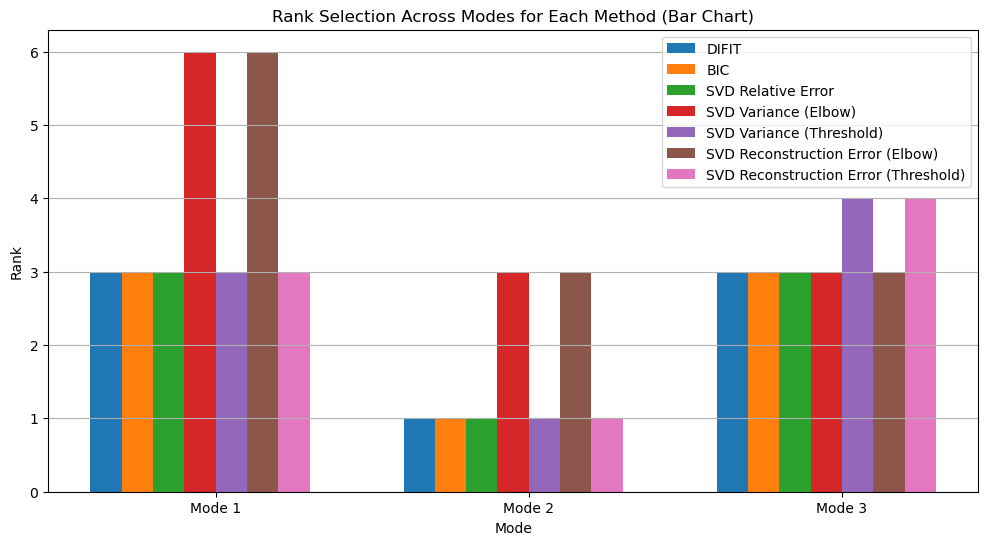

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define modes (x-axis)
modes = [1, 2, 3]

# Extract method names
methods = list(rank_dictionaries.keys())
num_methods = len(methods)

# Set width for bars and x offsets
bar_width = 0.1  
x_positions = np.arange(len(modes))  # Positions for modes on x-axis

# Prepare figure
plt.figure(figsize=(12, 6))

# Iterate over each method and plot as bars
for idx, method in enumerate(methods):
    if "tensor_70" in rank_dictionaries[method]:  # Use tensor_70 as reference
        ranks = rank_dictionaries[method]["tensor_70"]  # Extract ranks for this method
        offset = (idx - num_methods / 2) * bar_width  # Offset bars for separation
        plt.bar(x_positions + offset, ranks, width=bar_width, label=method)

# Labels and title
plt.xlabel("Mode")
plt.ylabel("Rank")
plt.title("Selected Ranks Across Modes for Each Method")
plt.xticks(x_positions, [f"Mode {m}" for m in modes])  # Ensure x-axis shows mode numbers
plt.legend(loc="best")  # Methods in legend
plt.grid(axis="y")

# Show plot
plt.show()


C:\Users\viola\AppData\Local\Temp\ipykernel_21312\1705525751.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_methods).colors


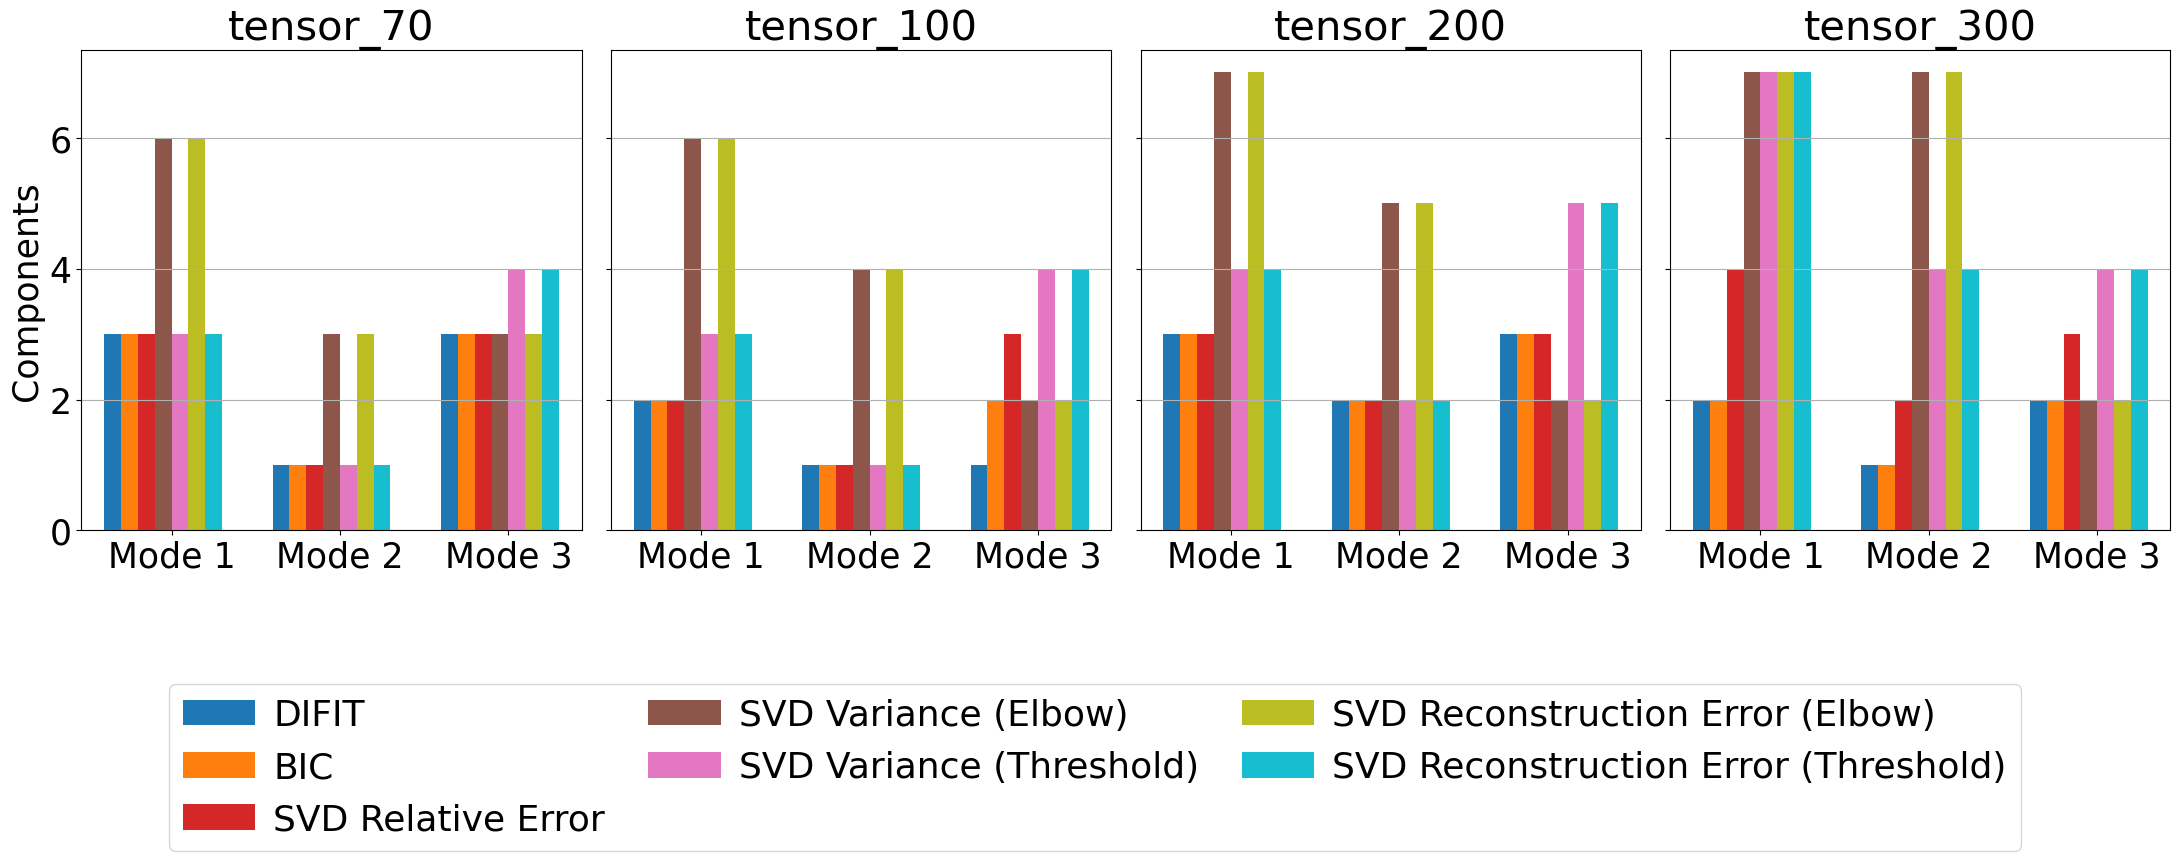

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Define modes (x-axis)
modes = [1, 2, 3]

# Extract method names
methods = list(rank_dictionaries.keys())
num_methods = len(methods)

# Define tensors to plot
tensor_names = ["tensor_70", "tensor_100", "tensor_200", "tensor_300"]

# Set width for bars and x offsets
bar_width = 0.1  
x_positions = np.arange(len(modes))  # Positions for modes on x-axis

# Prepare subplots
fig, axes = plt.subplots(1, len(tensor_names), figsize=(22, 7), sharey=True)

# Define colors for better visibility
colors = plt.cm.get_cmap("tab10", num_methods).colors  

# Iterate over each tensor and create a subplot
for ax, tensor in zip(axes, tensor_names):
    # Iterate over each method and plot as bars
    for idx, method in enumerate(methods):
        if tensor in rank_dictionaries[method]:  # Ensure the tensor exists in the method
            ranks = rank_dictionaries[method][tensor]  # Extract ranks for this method
            offset = (idx - num_methods / 2) * bar_width  # Offset bars for separation
            ax.bar(x_positions + offset, ranks, width=bar_width, label=method, color=colors[idx])

    # Labels and title
    ax.set_title(f"{tensor}", fontsize=30)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"Mode {m}" for m in modes], fontsize=25)
    ax.tick_params(axis='y', labelsize=25)  # Increase y-axis tick size
    ax.grid(axis="y")

# Set shared y-label
axes[0].set_ylabel("Components", fontsize=25)

# Move legend below all subplots, allowing multi-row display
fig.legend(
    methods, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.4),
    fontsize=26, columnspacing=1.2, handletextpad=0.5
)

# Adjust layout to fit legend properly
plt.tight_layout(rect=[0, 0, 1, 0.85])

# Save the figure as a PDF
plt.savefig("rank_selection_plots.pdf", format="pdf", bbox_inches="tight")


In [69]:

import pickle

# Define the path for saving
save_path = "rank_selection_results.pkl"

# Save the dictionary using Pickle (binary format)
with open(save_path, "wb") as pickle_file:
    pickle.dump(rank_dictionaries, pickle_file)

print(f"Rank selection results saved successfully to {save_path} (Pickle format)")



Rank selection results saved successfully to rank_selection_results.pkl (Pickle format)
